In [1]:
import torch
import pandas as pd
import os

In [2]:
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from nlpaug.augmenter.word import ContextualWordEmbsAug
import random
from utils.x_flow.pandas import PandasPipeline
from typing import Sized, Iterable, Union, Any, Optional
from tqdm import tqdm
import numpy as np
from utils.x_flow.pandas import ReadFile

In [5]:
class Augmenter:
    def __init__(self, model_name = "roberta-base", device_name ="cpu", method = None, batch_size: int =32):
        self.method = method or ContextualWordEmbsAug(
            model_path=model_name, action="insert", device=device_name, batch_size=batch_size
        )

    def augment(self, texts: Union[Sized, Iterable]):
        try:
            return self.augmentation_step(texts)
        except Exception as e:
            print(f"Error: {e}\n"
                  f"Returning original texts")
            return texts

    def augmentation_step(self, texts: Union[Sized, Iterable]):
        return self.method.augment(texts, n=len(texts))

In [6]:
aug = Augmenter(device_name="cuda")

In [7]:
aug.augment(
    ["My name is Parag",
    "I live in India"]
)

['My name really is Rahul Parag', 'I cannot live legally in India']

In [8]:
class Augmentation(PandasPipeline):
    def __init__(self, tol: int, delta: int,
                 epsilon: int, augmenter: Any,
                 batch_size: int,
                 output_file: str,
                 random_state: Optional[int] = None,
                 fresh_start: bool = True):
        super().__init__()
        if not all(isinstance(v, int) and v >= 0 for v in [tol, delta, epsilon]):
            raise ValueError("Parameters 'tol', 'delta', and 'epsilon' must be non-negative integers.")

        self.delta = delta
        self.epsilon = epsilon
        self.tol = tol
        self.augmenter = augmenter
        self.random_state = random_state or random.randint(1, 100)
        self.batch_size = batch_size
        self.output_file = output_file
        self.fresh_start = fresh_start
        tqdm.pandas()

    @staticmethod
    def make_directory(filename):
        folder_name = os.path.dirname(filename)  # Get the directory name from the file path
        if folder_name:  # Ensure the directory is not empty
            os.makedirs(folder_name, exist_ok=True)
        return filename

    def process_df(self, x: pd.DataFrame) -> str:
        # Calculate class counts
        self.validate_df(x, ["review_score", "review_text"])
        counts = x['review_score'].value_counts()
        minority, majority = (0, 1) if counts[0] < counts[1] else (1, 0)
        minority_counts = counts[minority]
        majority_counts = counts[majority]

        # Check if augmentation is needed
        if majority_counts - minority_counts <= self.tol:
            self.log("No need to augment")
            res =  pd.DataFrame(columns=x.columns)
            res.to_csv(self.output_file, encoding="utf-8")
            return self.output_file
        if minority_counts == 0 or majority_counts == 0:
            self.log("Skipping augmentation due to extreme class imbalance.")
            res =  pd.DataFrame(columns=x.columns)
            res.to_csv(self.output_file, encoding="utf-8")
            return self.output_file

        # Calculate augmentation lengths
        rng = np.random.default_rng(self.random_state)
        minority_augs_len = (
            majority_counts - minority_counts + self.delta + rng.integers(-self.epsilon, self.epsilon + 1)
        )
        majority_augs_len = self.delta + rng.integers(-self.epsilon, self.epsilon + 1)
        total_augs_len = minority_augs_len+majority_augs_len

        # Log augmentation details
        self.log(
            f"Counts: Minority [{minority}]: {minority_counts}, Majority [{majority}]: {majority_counts}"
        )
        self.log(
            f"To augment:\n"
            f"- {minority_augs_len} minority instances\n"
            f"- {majority_augs_len} majority instances\n"
            f"- Total = {total_augs_len}\n"
            f"- No. of batches = {int(np.ceil(total_augs_len/self.batch_size))}"
        )

        # Sample candidates
        minority_candidates = x[x['review_score'] == minority].sample(
            n=minority_augs_len, replace=(minority_augs_len>minority_counts), random_state=self.random_state
        ).copy()
        majority_candidates = x[x['review_score'] == majority].sample(
            n=majority_augs_len, replace=(majority_augs_len>majority_counts), random_state=self.random_state
        ).copy()

        data = pd.concat([minority_candidates, majority_candidates], axis=0).reset_index(drop=True)
        data = data.sample(len(data))

        if os.path.exists(self.output_file) and self.fresh_start:
            os.remove(self.output_file)

        output_file = self.make_directory(self.output_file)
        with open(output_file, mode="w", newline='', encoding="utf-8") as f_out:
            header_written = False
            # num_batches = int(len(data)/self.batch_size)
            for start_idx in tqdm(range(0, len(data), self.batch_size),desc=f"Augmenting"):
                end_idx = min(start_idx + self.batch_size, len(data))
                curr_batch = data.iloc[start_idx:end_idx, :].copy()
                curr_batch['review_text'] = self.augmenter.augment(curr_batch['review_text'].tolist())
                curr_batch.to_csv(f_out, index=False, mode='a', header=not header_written, encoding="utf-8")
                header_written = True
        return self.output_file

In [9]:
from utils.x_flow.base import PipeLambda
from utils.x_flow.pandas import ReadFile, WriteFile

In [10]:
batch_size = 32
augmentation_pipeline = ReadFile() >>\
                        PipeLambda(func = lambda x: x.sample(10000), name = "Sampling") >>\
                        Augmentation(tol = 50,
                                     delta=100,
                                     epsilon=50,
                                     augmenter=Augmenter(model_name = "roberta-base",batch_size=batch_size,
                                                         device_name = 'cuda' if torch.cuda.is_available() else 'cpu'),
                                     random_state=42, batch_size=batch_size, fresh_start=True,
                                     output_file="data/augmented/aug_1.csv")

In [11]:
augmentation_pipeline.sequence

'Execution order: FileLoader->Sampling->Augmentation'

In [12]:
path = augmentation_pipeline.step("data/preprocessed/cleaned.csv")

1.Running FileLoader:
Successfully read file: data/preprocessed/cleaned.csv
2.Running Sampling:
3.Running Augmentation:
Counts: Minority [0]: 1731, Majority [1]: 8269
To augment:
- 6597 minority instances
- 128 majority instances
- Total = 6725
- No. of batches = 211


Augmenting: 100%|██████████| 211/211 [1:25:50<00:00, 24.41s/it]


In [13]:
adf = pd.read_csv(path)

In [14]:
adf

,app_id,app_name,review_text,review_score,urls,contains_url,raw_text,review_length,word_counts
0,311210,Call of Duty: Black Ops III,bored.,0,[],False,bored.,6,1
1,206420,Saints Row IV,due to you the fact means that this is just th...,0,[],False,Due to the fact that this is just The Trouble ...,340,61
2,222880,Insurgency,"i didnt play up it much, and my friend is shar...",0,[],False,"I didn't play it much, and my friend share-ed ...",161,36
3,348020,NaN,"this game is absolutely awful, the controls ar...",0,[],False,"This game is absolutely awful, the controls ar...",342,63
4,253510,Warmachine Tactics,really are poor work from the devs who just se...,0,[],False,Really poor work from the devs who just seem t...,298,61
...,...,...,...,...,...,...,...,...,...
6720,12210,Grand Theft Auto IV: The Complete Edition,dosent cosmetic work steam ass just wants you ...,0,[],False,dosent work steam just wants you money,38,7
6721,466910,Worm.is: The Game,new update ah made no lag unbearable,0,[],False,NEW UPDATE MADE LAG UNBEARABLE,30,5
6722,364360,Total War: WARHAMMER,"ive really enjoyed playing this game, however ...",0,[],False,"I\'ve really enjoyed playing this game, howeve...",272,51
6723,330070,NaN,"i like this software, lol but i think thats ju...",0,[],False,"I like this software, but I think that's just ...",588,109


In [15]:
adf.duplicated().sum()

46

In [16]:
df = pd.read_csv("data/preprocessed/cleaned.csv")

In [17]:
combined = pd.concat([adf,df], axis=0)

In [18]:
combined.duplicated().sum()

58

In [19]:
combined['review_score'].value_counts()

review_score
1    13730
0     9484
Name: count, dtype: int64

In [20]:
df['review_score'].value_counts()

review_score
1    13602
0     2887
Name: count, dtype: int64

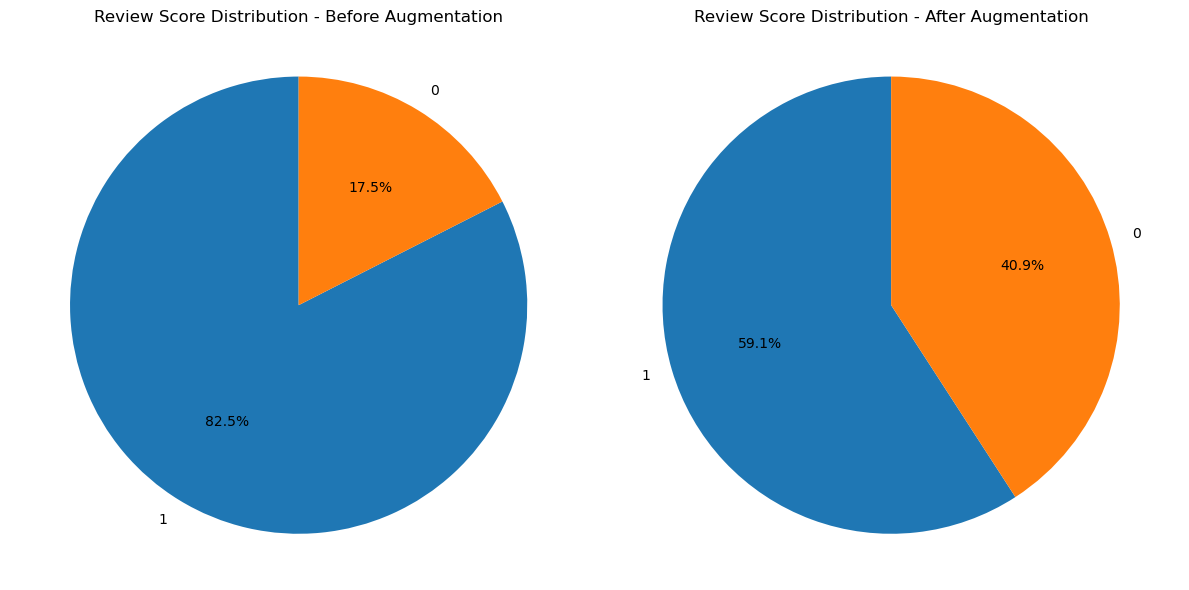

In [21]:
import matplotlib.pyplot as plt

# Get the value counts for 'before' and 'after'
before = df['review_score'].value_counts()
after = combined['review_score'].value_counts()

# Create the pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot pie chart for 'before'
axes[0].pie(before, labels=before.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Review Score Distribution - Before Augmentation')
axes[0].axis('equal')  # Equal aspect ratio ensures the pie chart is a circle.

# Plot pie chart for 'after'
axes[1].pie(after, labels=after.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Review Score Distribution - After Augmentation')
axes[1].axis('equal')  # Equal aspect ratio ensures the pie chart is a circle.

# Display the plots
plt.tight_layout()
plt.show()


In [22]:
combined

,app_id,app_name,review_text,review_score,urls,contains_url,raw_text,review_length,word_counts
0,311210,Call of Duty: Black Ops III,bored.,0,[],False,bored.,6,1
1,206420,Saints Row IV,due to you the fact means that this is just th...,0,[],False,Due to the fact that this is just The Trouble ...,340,61
2,222880,Insurgency,"i didnt play up it much, and my friend is shar...",0,[],False,"I didn't play it much, and my friend share-ed ...",161,36
3,348020,NaN,"this game is absolutely awful, the controls ar...",0,[],False,"This game is absolutely awful, the controls ar...",342,63
4,253510,Warmachine Tactics,really are poor work from the devs who just se...,0,[],False,Really poor work from the devs who just seem t...,298,61
...,...,...,...,...,...,...,...,...,...
16484,255710,Cities: Skylines,some times this game will ♥♥♥♥ you over realy ...,1,[],False,some times this game will ♥♥♥♥ YOU OVER REALY ...,188,41
16485,250110,Assault Android Cactus,really solid twin stick shooter with tight con...,1,[],False,Really solid twin stick shooter with tight con...,849,149
16486,205950,Jet Set Radio,super brother,1,[],False,Super brother,13,2
16487,377160,Fallout 4,friggin awesome but not quite as good as fnv yet.,1,[],False,Friggin awesome but not quite as good as FNV.....,49,10


In [23]:
combined[['app_id', 'app_name', 'review_text', 'review_score']].to_csv("data/preprocessed/combined.csv", index=False)